In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

Будем считать энтропию по такой формуле:
$$
H(p_1, ..., p_n) = -\sum_{i=1}^n p_i\ln p_i,
$$
где $p_i$ - вероятрость класса $k_i$ в вершине.

In [2]:
h_rm = -(8/10 * np.log(8/10) + 2/10 * np.log(2/10)) # считаем по формуле

print(round(h_rm, 2)) # выводим с округлением

0.5


**Задание 1.2** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
h_Rm = 8/10 * (1 - 8/10) + 2/10 * (1 - 2/10) # считаем по формуле
h_Rl = 0 # логично, так как нет неопределённости в поддереве, и по формуле тоже будет 0
h_Rr = 0 # логично, так как нет неопределённости в поддереве, и по формуле тоже будет 0

Q_Rm_j_t = h_Rm - 8/10 * h_Rl - 2/10 * h_Rr # считаем по формуле

print(round(Q_Rm_j_t, 2))

0.32


**Задание 1.3** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
# среднему значению

terminal_node = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

prediction = terminal_node.mean() # считаем среднее значение

print(prediction) 

40.6


## Часть 2: Решающие деревья

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

In [6]:
def find_thresholds(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    feature_type: str = "real"
) -> np.ndarray:
    """
    Функция для нахождения трешхолдов
    """
    
    # БОНУС. Обработка пропусков
    # Если признак вещественный, то пропуск заменим средним значением
    nan_mask = np.isnan(feature_vector)
    feature_mean = np.mean(feature_vector[~nan_mask])
    feature_vector = np.where(nan_mask, feature_mean, feature_vector)
    
    if feature_type == "real":
        thresholds = pd.Series(sorted(Counter(feature_vector).keys())).rolling(window=2).mean().iloc[1:].values
        
        return thresholds
    # В такой реализации пропуск в категориальном признаке будет считаться отдельным классом, тут всё ОК.
    elif feature_type == "categorical":
        thresholds = np.unique(feature_vector)
        
        return thresholds
    
    raise LookupError(f'unknown feature_type: {feature_type}')  

In [7]:
def find_distributions(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series], 
    threshold: Union[float, int, str],
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Функция для нахождения распределений по трешхолду
    """
    
    if feature_type == "real":
        R_l = target_vector[feature_vector < threshold]
        R_r = target_vector[feature_vector >= threshold]
        
        return R_l, R_r
    elif feature_type == "categorical":
        R_l = target_vector[feature_vector == threshold]
        R_r = target_vector[feature_vector != threshold]
        
        return R_l, R_r
    
    raise LookupError(f'unknown feature_type: {feature_type}')    

In [8]:
def find_impurity(
    target_distribution: np.ndarray, 
    task: str = "classification"
) -> float:
    """
    Функция для нахождения Impurity по распределению
    """
    
    if task == "regression":
        H = np.var(target_distribution)
        
        return H
    elif task == "classification":
        probabilities = np.array(list(Counter(target_distribution).values())) / len(target_distribution)
        
        H = sum(probabilities * (1-probabilities))
        
        return H
    
    raise LookupError(f'unknown task: {task}')

In [9]:
def find_gini_for_threshhold(
    threshold: Union[float, int, str],
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"                      
) -> float:
    """
    Функция для нахождения критерия информативности по трешхолду
    """
    
    R_m = target_vector

    H_m = find_impurity(R_m, task)
    
    R_l, R_r = find_distributions(feature_vector, target_vector, threshold, feature_type)

    H_l = find_impurity(R_l, task)
    H_r = find_impurity(R_r, task)
    
    Q = H_m - len(R_l)/len(R_m) * H_l - len(R_r)/len(R_m) * H_r
    
    return Q

In [10]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух соседних (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    
    thresholds = np.array(find_thresholds(feature_vector, feature_type))

    find_ginis = np.vectorize(
        find_gini_for_threshhold, 
        excluded={1, 2, 3, 4}
    )
    
    ginis = find_ginis(thresholds, feature_vector, target_vector, task, feature_type)
    
    gini_best_index = np.argmax(ginis)
    gini_best = ginis[gini_best_index]
    
    threshold_best = thresholds[gini_best_index]
    
    
    return thresholds, ginis, threshold_best, gini_best 

Эту функцию можно протестировать на датасете `California`.

In [11]:
from sklearn.datasets import fetch_california_housing

In [12]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

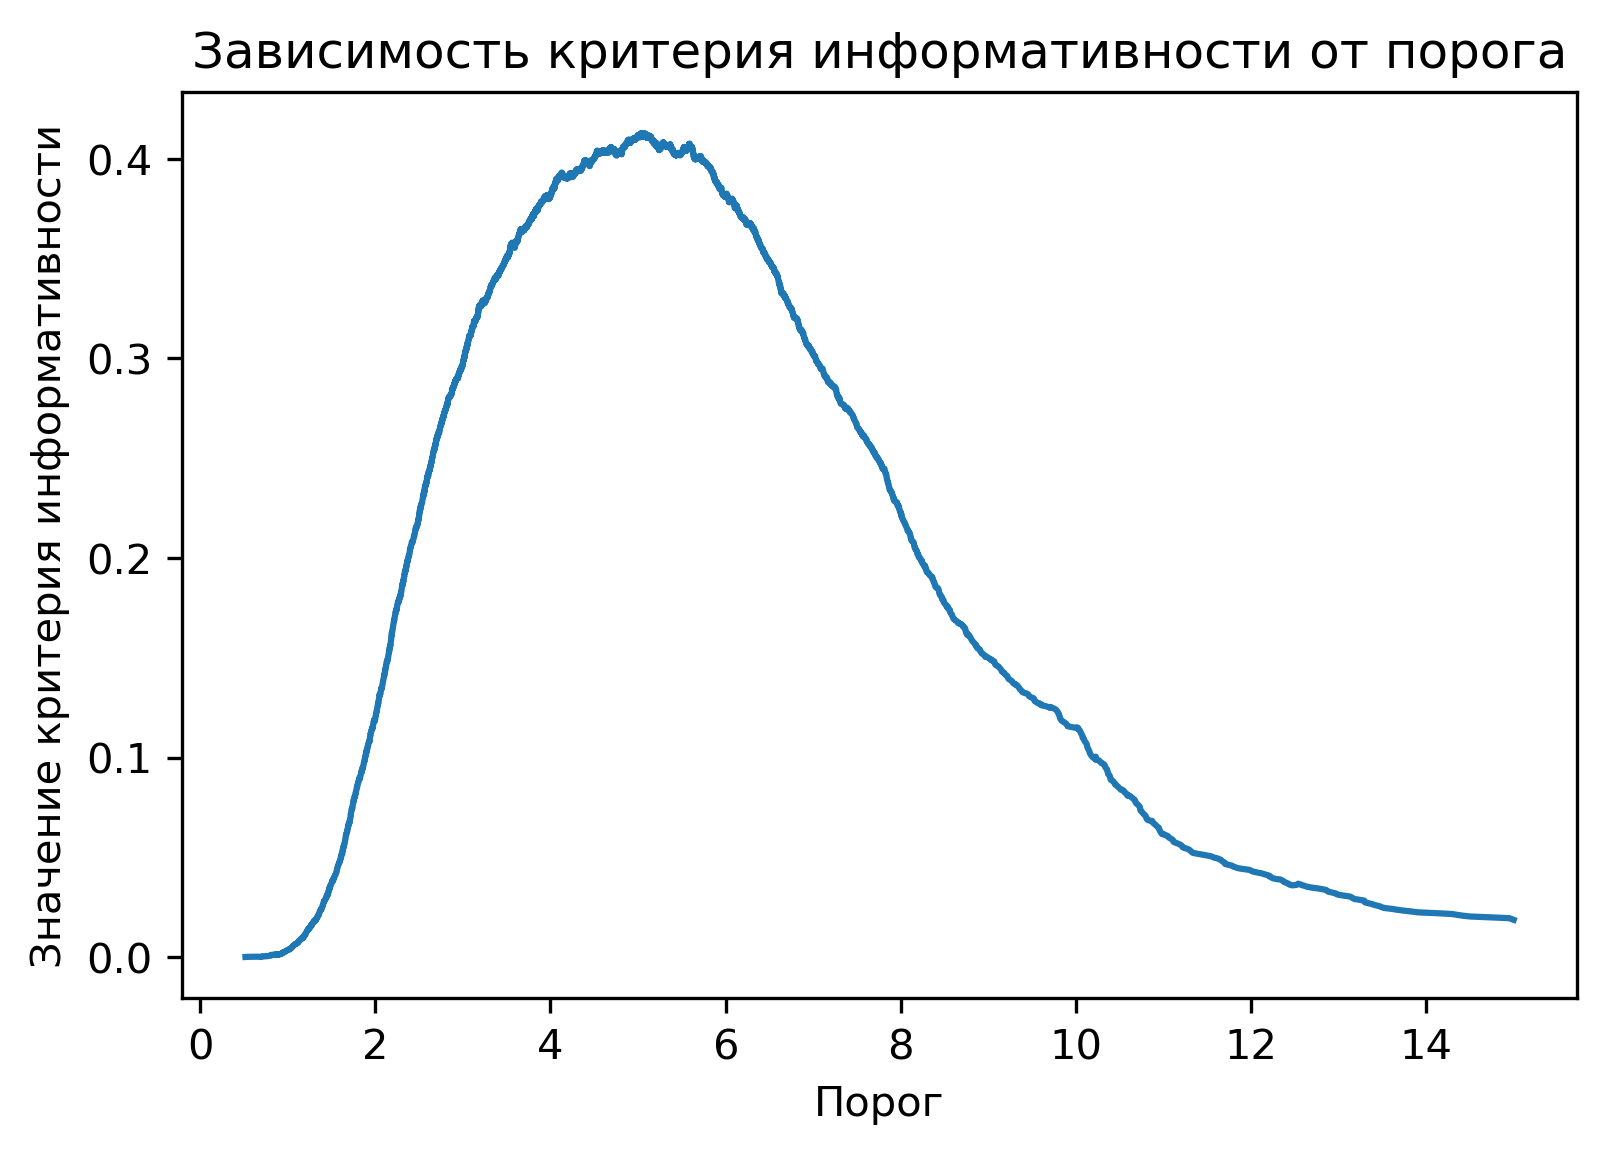

In [13]:
fig, ax = plt.subplots()

fig.dpi = 300

x_axis = find_best_split(X.MedInc, y, "regression", "real")[0]
y_axis = find_best_split(X.MedInc, y, "regression", "real")[1]

ax.plot(x_axis, y_axis)

ax.set_ylabel('Значение критерия информативности')
ax.set_xlabel('Порог')
ax.set_title('Зависимость критерия информативности от порога')

plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [14]:
# для этого нужно применить написанную выше функцию к каждому признаку, и среди лучших найти лучший

find_best_predicate = lambda column: (find_best_split(X[column], y, 'regression', 'real')[3], 
                                      find_best_split(X[column], y, 'regression', 'real')[2])

find_best_predicates = np.vectorize(find_best_predicate)

# кортеж с двумя np.ndarray, в первом - лучшие Джини, во втором - соответствующие им предикаты
best_predicates = find_best_predicates(X.columns) 

best_predicate_index = np.argmax(best_predicates[0])
best_predicate = best_predicates[1][best_predicate_index]

best_predicate_column = X.columns[best_predicate_index]

print(f'Наилучший предикат для первой вершины: {best_predicate_column} < {best_predicate}')

Наилучший предикат для первой вершины: MedInc < 5.035150000000001


**Задание 2.2** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в данных и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [15]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # важность признаков будет считаться как сумма значений критерия информативности признака в вершинах
        self._feature_importances_tmp = {i: list() for i in range(len(feature_types))}
        
        self._feature_importances = {}

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
        
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])
        
        # запоминаем лучший gini в ребре, чтобы считать важность признаков
        self._feature_importances_tmp[feature_best].append(gini_best)

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        
        if node["type"] == "terminal":
            return node["class"]
        
        feature_split = node["feature_split"]
        
        if self._feature_types[feature_split] == "real":
            threshold = node["threshold"]
            
            if x[feature_split] < threshold:
                return self._predict_node(x, node["left_child"])
            
            return self._predict_node(x, node["right_child"])
        elif self._feature_types[feature_split] == "categorical":
            category_split = node["category_split"]
            
            if x[feature_split] == category_split:
                return self._predict_node(x, node["left_child"])
            
            return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)
        
        # посчитаем важности признаков
        for i in self._feature_importances_tmp.keys():
            if len(self._feature_importances_tmp[i]) != 0:
                self._feature_importances[i] = np.sum(self._feature_importances_tmp[i])
            else:
                self._feature_importances[i] = 0

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [16]:
students = pd.read_csv('https://raw.githubusercontent.com/LexusShabunya/projects/main/DATA/students.csv').drop(columns = 'Unnamed: 0')

X = students.iloc[:, :5]
y = students.UNS

X.head()

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24


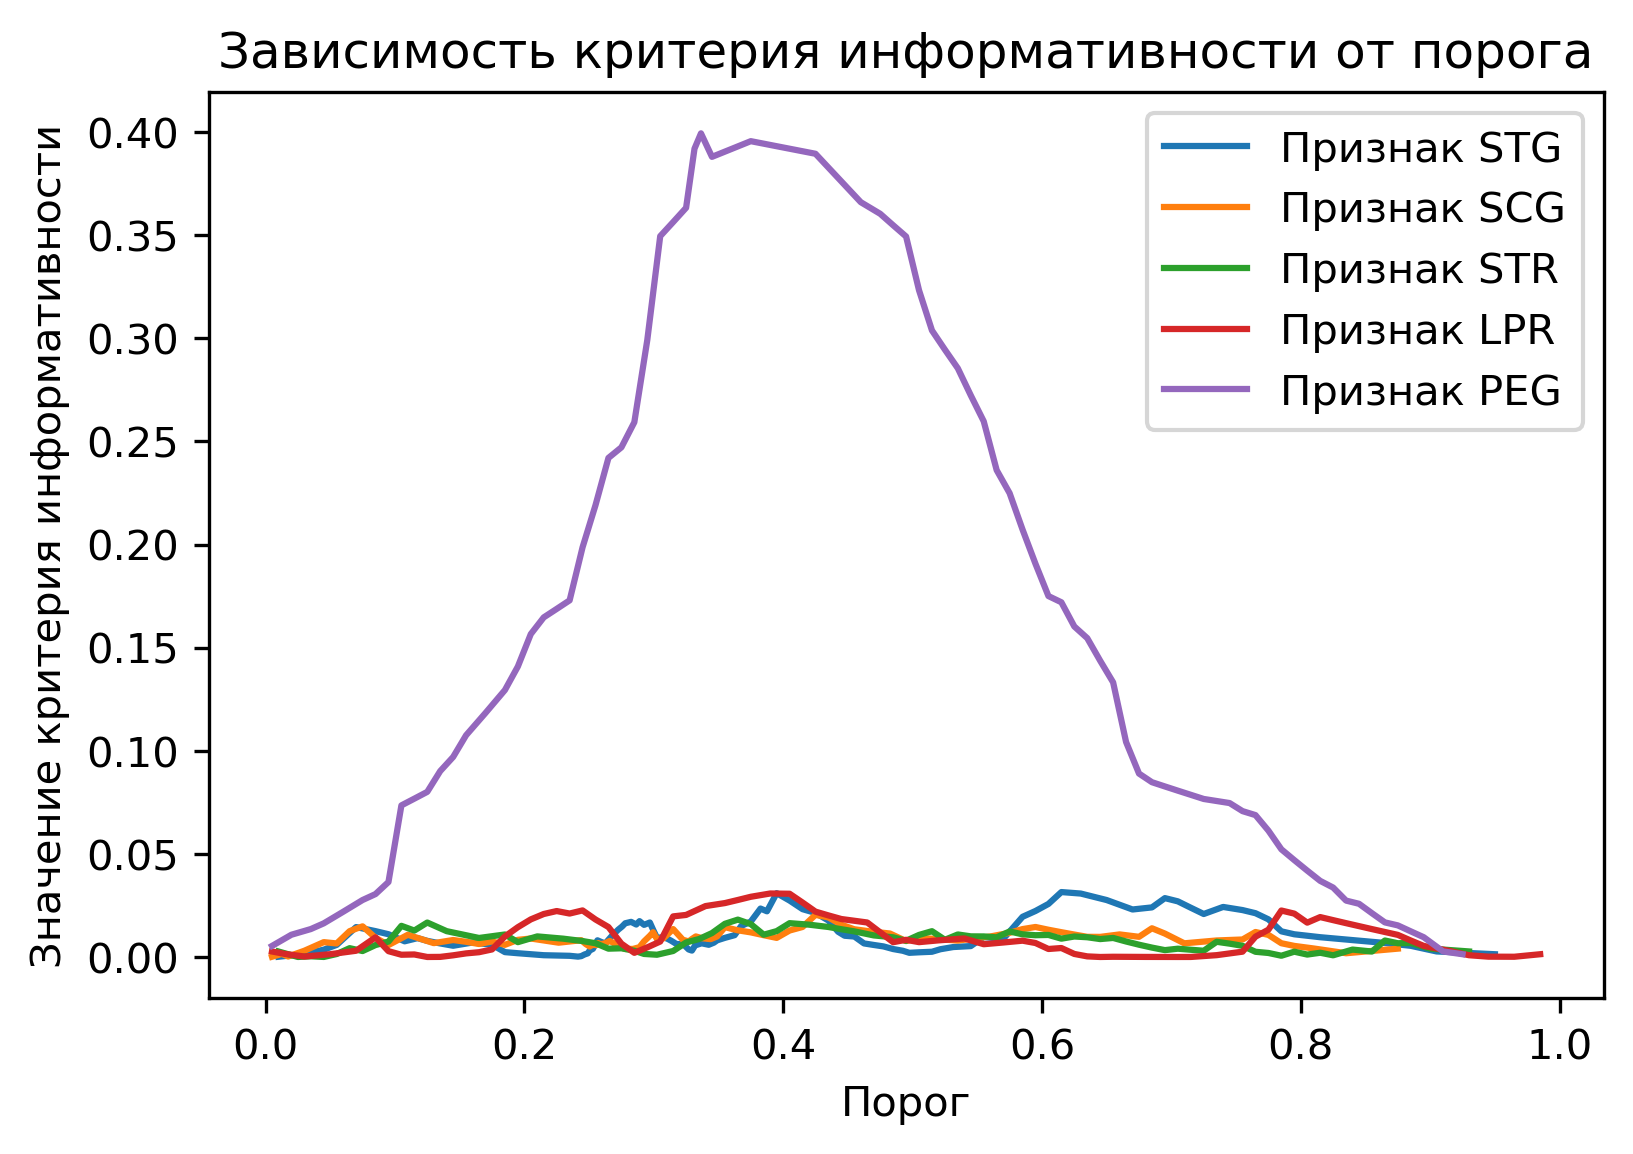

In [17]:
fig, ax = plt.subplots(dpi = 300)

ax.plot(find_best_split(X.STG, y, "classification", "real")[0], 
        find_best_split(X.STG, y, "classification", "real")[1], 
        label='Признак STG')

ax.plot(find_best_split(X.SCG, y, "classification", "real")[0], 
        find_best_split(X.SCG, y, "classification", "real")[1], 
        label='Признак SCG')

ax.plot(find_best_split(X.STR, y, "classification", "real")[0], 
        find_best_split(X.STR, y, "classification", "real")[1], 
        label='Признак STR')

ax.plot(find_best_split(X.LPR, y, "classification", "real")[0], 
        find_best_split(X.LPR, y, "classification", "real")[1], 
        label='Признак LPR')

ax.plot(find_best_split(X.PEG, y, "classification", "real")[0], 
        find_best_split(X.PEG, y, "classification", "real")[1], 
        label='Признак PEG')

ax.set_ylabel('Значение критерия информативности')
ax.set_xlabel('Порог')
ax.set_title('Зависимость критерия информативности от порога')
ax.legend()

plt.show()

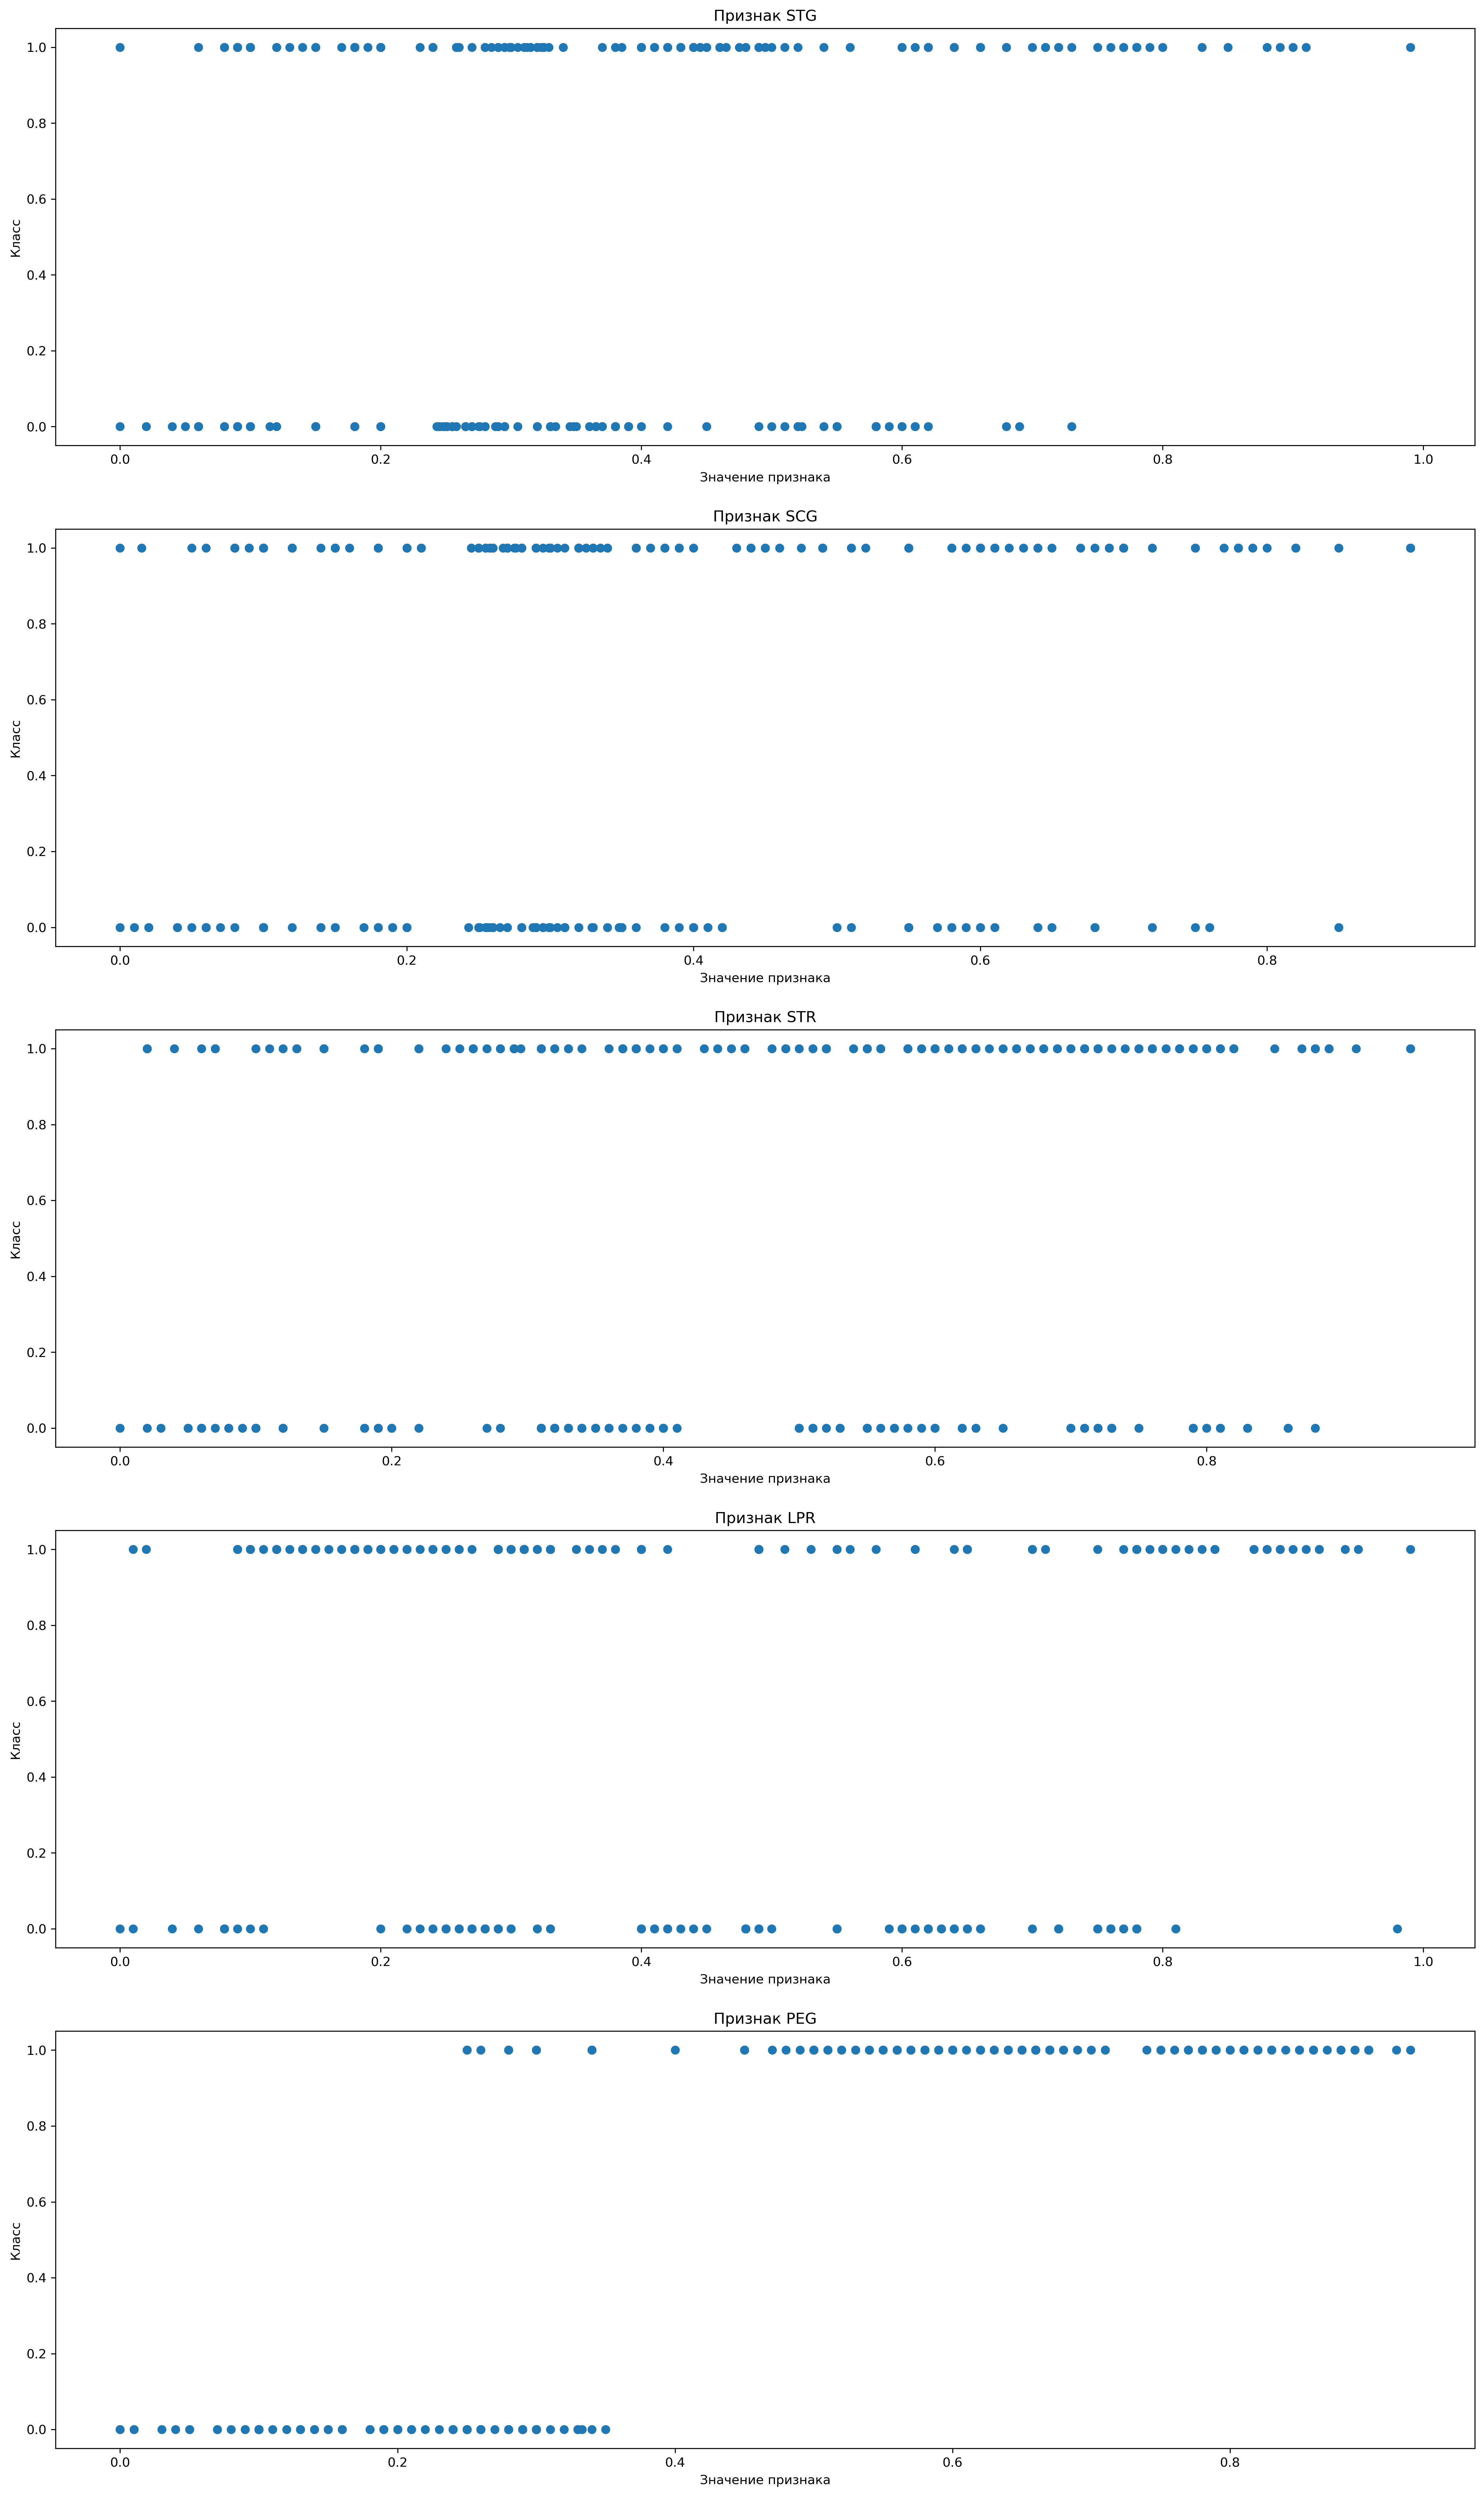

In [18]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 35), dpi=300)

for ax, feature in zip(axes, X.columns):
    ax.scatter(X[feature], y)

    ax.set_ylabel('Класс')
    ax.set_xlabel('Значение признака')
    ax.set_title(f'Признак {feature}')

plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Вывод:** очевидно что делить нужно по признаку `PEG`. Это согласуется с оценкой диаграмм рассеяния. Для хороших признаков кривая имеет вид "высокой горы" (Эверест), а диаграмма рассеяния имеет такой вид, что до какого-то значения признака класс один, а после этого значения класс другой. У плохих признаков кривая колеблется вверх-вниз совсем незначительно и не имеет "высоких горных пиков" (Уральские горы).

**Задание 2.4** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [19]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data',
                  header=None)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [20]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

data = data.apply(lambda col: encoder.fit_transform(col), axis=0)

X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,5,2,4,1,6,1,0,1,4,0,...,2,7,7,0,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=228)

In [22]:
from sklearn.metrics import accuracy_score

my_tree = DecisionTree(feature_types=["categorical" for _ in range(X_train.shape[1])]) # посадили дерево

my_tree.fit(np.array(X_train), np.array(y_train)) # учим дерево

y_pred = my_tree.predict(np.array(X_test)) # прогноз дерева

accuracy = accuracy_score(y_test, y_pred) # измеряем accuracy

print(f'Accuracy кастомного дерева: {accuracy}')

# дерево идеально работает на этих данных

Accuracy кастомного дерева: 1.0


## Часть 3: Бэггинг и случайный лес

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [23]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [24]:
data = pd.read_csv('https://raw.githubusercontent.com/LexusShabunya/projects/main/DATA/diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

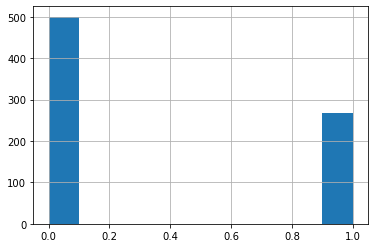

In [25]:
data['Outcome'].hist()
plt.show()

**Задание 3.1** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [26]:
X = data.drop(columns=['Outcome']) # признаки

y = data.Outcome # целевая переменная

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=228) # делаем обучающую и тестовую выборку

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=228) # делаем обучающую-обучающую и обучающую-валидационную выборку

**Задание 3.2** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [28]:
max_depths = np.arange(1, 101) # списки со значениями для перебора
min_samples_leafs = np.arange(1, 501)


best_score = -1 # заведомо наименьшее значение f1-score

for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
        
        tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf) # садим дерево
        
        tree.fit(X_train_train, y_train_train) # обучаем дерево с параметрами
        
        y_pred = tree.predict(X_train_val) # прогноз дерева
        
        score = f1_score(y_train_val, y_pred) # смотрим f1-score

        if score > best_score: # если он лучше чем то, что было лучшим, делаем его лучшим и запоминаем параметры
            best_score = score
            best_max_depth = max_depth
            best_min_samples_leaf = min_samples_leaf
            
        
print(f'Лучший max_depth: {best_max_depth}')
print(f'Лучший min_samples_leaf: {best_min_samples_leaf}')
print(f'Лучшая F1-мера: {best_score}')

Лучший max_depth: 1
Лучший min_samples_leaf: 168
Лучшая F1-мера: 0.6222222222222223


In [29]:
tree = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf) # садим дерево с лучшими параметрами

tree.fit(X_train, y_train) # учим дерево с лучшими параметрами

y_pred = tree.predict(X_test) # прогноз дерева

print(f'Accuracy решающего дерева на тестовых данных: {accuracy_score(y_test, y_pred)}')
print(f'Precision решающего дерева на тестовых данных: {precision_score(y_test, y_pred)}')
print(f'Recall решающего дерева на тестовых данных: {recall_score(y_test, y_pred)}')
print(f'AUC-ROC решающего дерева на тестовых данных: {roc_auc_score(y_test, y_pred)}')

# не очень-то и плохая, а главное довольно простая модель

Accuracy решающего дерева на тестовых данных: 0.7359307359307359
Precision решающего дерева на тестовых данных: 0.6486486486486487
Recall решающего дерева на тестовых данных: 0.5783132530120482
AUC-ROC решающего дерева на тестовых данных: 0.7013187886681863


**Задание 3.3** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [30]:
bagging = BaggingClassifier(n_estimators=50, random_state=228) # создаём модель

bagging.fit(X_train, y_train) # обучаем модель 

y_pred = bagging.predict(X_test) # прогноз модели

print(f'Accuracy бэггинга на тестовых данных: {accuracy_score(y_test, y_pred)}')
print(f'Precision бэггинга на тестовых данных: {precision_score(y_test, y_pred)}')
print(f'Recall бэггинга на тестовых данных: {recall_score(y_test, y_pred)}')
print(f'AUC-ROC бэггинга на тестовых данных: {roc_auc_score(y_test, y_pred)}')

# качество на бэггинге получше чем на решающем дереве

Accuracy бэггинга на тестовых данных: 0.7532467532467533
Precision бэггинга на тестовых данных: 0.696969696969697
Recall бэггинга на тестовых данных: 0.5542168674698795
AUC-ROC бэггинга на тестовых данных: 0.7095408661673723


**Задание 3.4** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [31]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV


max_depths = np.arange(1, 31) # списки со значениями для перебора
min_samples_leafs = np.arange(1, 51)

# данную операцию можно сделать с помощью GridSearchCV

params = {'max_depth': max_depths, 
         'min_samples_leaf': min_samples_leafs}

random_forest = RandomForestClassifier(n_estimators=50, random_state=228)

clf = GridSearchCV(estimator=random_forest, param_grid=params, scoring=make_scorer(f1_score))

clf.fit(X_train, y_train)


best_score = clf.best_score_
best_max_depth = clf.best_params_['max_depth']
best_min_samples_leaf= clf.best_params_['min_samples_leaf']

print(f'Лучшая F1-мера: {best_score}')
print(f'Лучший max_depth: {best_max_depth}')
print(f'Лучший best_min_samples_leaf: {best_min_samples_leaf}')

Лучшая F1-мера: 0.6365872297637003
Лучший max_depth: 11
Лучший best_min_samples_leaf: 4


In [32]:
random_forest = RandomForestClassifier(n_estimators=50, 
                                       max_depth=best_max_depth, 
                                       min_samples_leaf=best_min_samples_leaf, 
                                       random_state=228)

random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

print(f'Accuracy бэггинга на тестовых данных: {accuracy_score(y_test, y_pred)}')
print(f'Precision бэггинга на тестовых данных: {precision_score(y_test, y_pred)}')
print(f'Recall бэггинга на тестовых данных: {recall_score(y_test, y_pred)}')
print(f'AUC-ROC бэггинга на тестовых данных: {roc_auc_score(y_test, y_pred)}')

Accuracy бэггинга на тестовых данных: 0.7619047619047619
Precision бэггинга на тестовых данных: 0.7413793103448276
Recall бэггинга на тестовых данных: 0.5180722891566265
AUC-ROC бэггинга на тестовых данных: 0.7083604689026376


**Вывод:** самым лучшим оказался RandomForest, однако он не настолько лучше, насколько дольше для него подбирались параметры.

**Задание 3.5 ** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [33]:
n_estimators_list = [i for i in range(1, 500)]

auc_roc_list = list()

for n_estimators in n_estimators_list:
    forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)
    
    forest.fit(X_train, y_train)
    
    y_pred = forest.predict(X_test)
    
    auc_roc_list.append(roc_auc_score(y_test, y_pred))

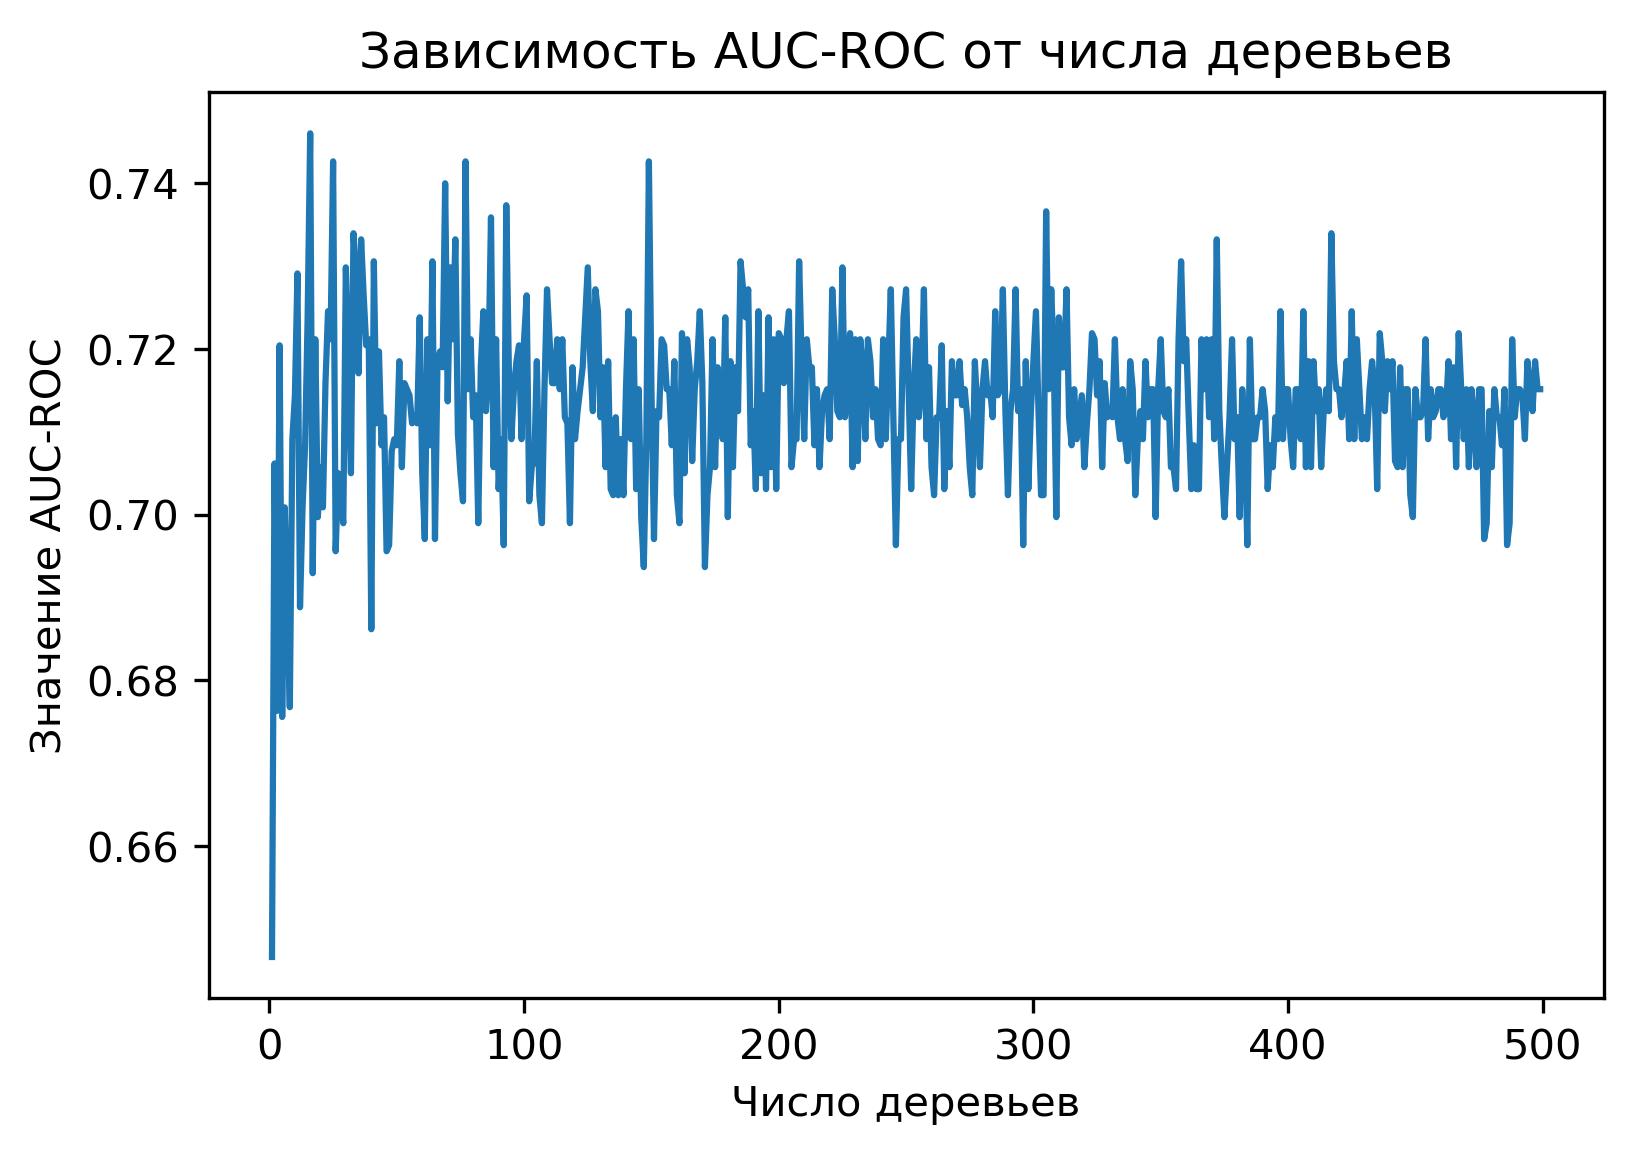

In [34]:
fig, ax = plt.subplots(dpi = 300)

ax.plot(n_estimators_list, auc_roc_list)

ax.set_ylabel('Значение AUC-ROC')
ax.set_xlabel('Число деревьев')
ax.set_title('Зависимость AUC-ROC от числа деревьев')

plt.show()

**Вывод:** при большом числе деревьев, значение AUC-ROC выходит на асимптоту и меняется не сильно.

**Задание 3.6 ** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

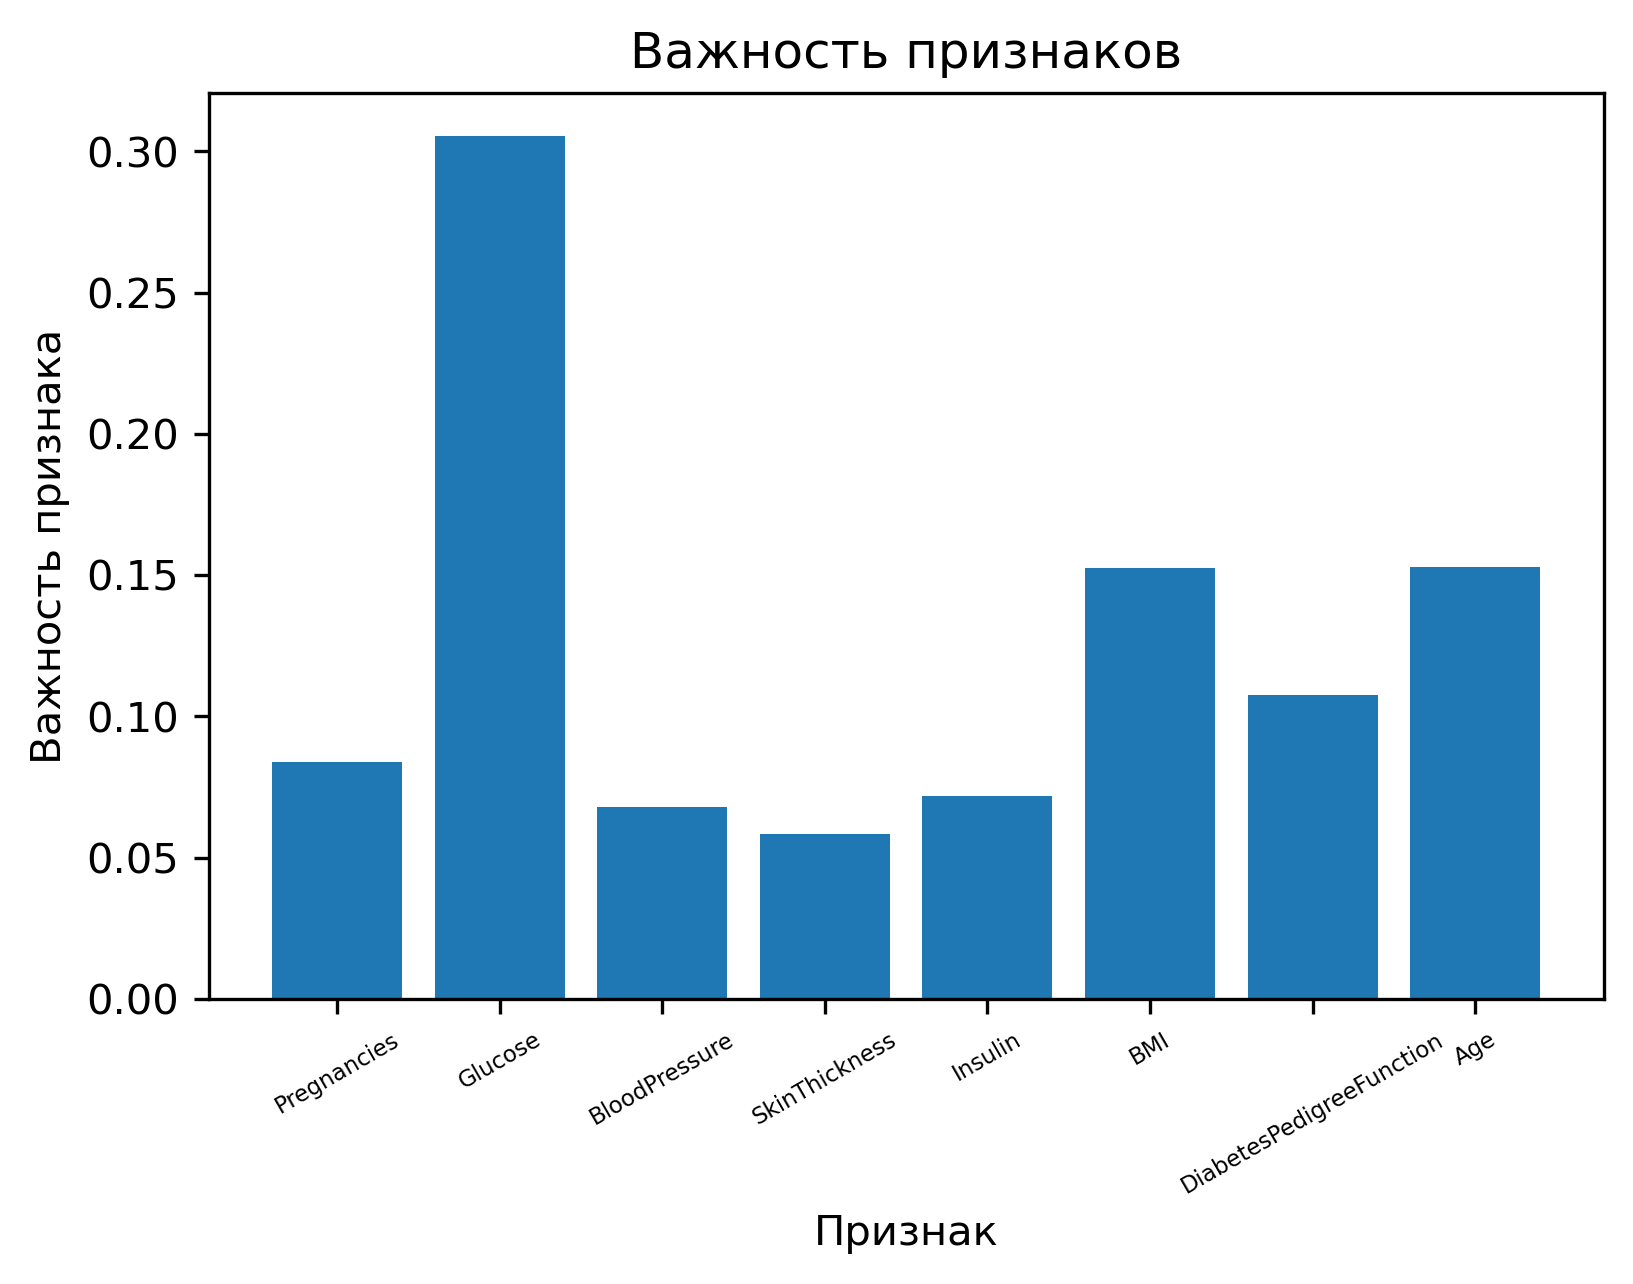

In [35]:
importances = random_forest.feature_importances_
feature_names = random_forest.feature_names_in_

fig, ax = plt.subplots(dpi=300)

ax.bar(feature_names, importances)

ax.set_ylabel('Важность признака')
ax.set_xlabel('Признак')
ax.set_title('Важность признаков')

ax.tick_params(axis='x', labelsize=5.5, labelrotation=30)

plt.show()

**Вывод:** для определения диабета самым важным признаком оказался уровень глюкозы.